## Plots for USGS Shoal Mapping Cruises 2021

Based on [plots-20170601.ipynb](https://drive.google.com/open?id=0B9IYEz9K_uS0TE1yblQ2M3hCUlU&resourcekey=0-W0GjnNuyP6toQR3h4Niteg&authuser=davids%40sfei.org&usp=drive_fs)

Original notes:

>  Using the 20s median / 30 s mean data.
>
>  Tweaks per DS email 
>
>    - standardize colorbars. EXO Chl up to 80+, 54, 20.  ISUS NO3 uM 4--40, 50, SUNA NO3 uM 26--62, 68. WetStar chl up to 60, 55, 33. 
>    - remove "extra" data (during mooring deployment) on 3/20.
>    - need to write uM unit data for the 4/05 cruise.
>  Minor tweaks for email for Warner.

Data copied from [google drive folder](https://drive.google.com/drive/folders/1ETUPNk2-HUUNz53NoTqqwNOcbMY4b9lB)

In [2]:
import datetime
import os
import glob
from collections import OrderedDict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colorbar import make_axes
from matplotlib.dates import num2date

import cmocean.cm as cmo

import ipywidgets as widgets

from stompy.plot import plot_utils, plot_wkb
import stompy.plot.cmap as scmap
# 'turbo' has the color range of jet but is perceptually uniform.
turbo=scmap.load_gradient('turbo.cpt')
from stompy.grid import unstructured_grid
from stompy.spatial import proj_utils, field, wkb2shp
from stompy import utils

%matplotlib notebook

/opt/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
# relative path in google drive to the data files
# individual sensors are in subdirectories
base_dir='.'
fig_dir="figs20211120"

os.path.exists(fig_dir) or os.mkdir(fig_dir)

True

In [4]:
# Get bathy, shoreline from a grid:
grid_fn="/home/rusty/runs/delft/dfm_southbay/20160803/South-Bay model/Run27/sfeiv5_net.nc"

In [5]:
grid=unstructured_grid.UnstructuredGrid.read_dfm(grid_fn)

In [6]:
# extra data for making nice geographic plots

# Define the extent of the plot up front so that it can be used to
# clip other layers like a DEM.
zoom=(535396., 603125, 4140837, 4194019.)

# Extract a shoreline from the grid as shapely.Polygon
poly=grid.boundary_polygon()

# The grid also has bathymetry in grid.nodes['depth'], which
# can be plotted with grid.contourf_node_values().

# Could also get bathy from raster file, as in:
# dem=field.GdalGrid('/home/rusty/data/bathy_dwr/joined-40m.tif',
#                    geo_bounds=utils.expand_xxyy(zoom,0.4))

INFO:join_features:0 open strings, 26 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3281596408.464742, 25 potential interiors


In [7]:
files=["Data_2021_03_23/preliminary_March2021_SBay_Mapping_2021-03-23_KO.xlsx",
       "Data_2021_05_05/preliminary_May_2021_southbay_mapping.xlsx",
       "Data_2021_06_23/preliminary_June_2021_southbay_mapping.xlsx",
       "Data_2021_08_04/T3_SBay_Mapping_2021-08-04.csv", 
       ]

In [8]:
# Build a list of pandas data frames, one per cruise.
l2u=proj_utils.mapper('WGS84','EPSG:26910')
    
dfs=[]
for fn in files:
    print("Reading",fn)
    if fn.endswith('.csv'):
        date_field='Timestamp (PST)'
        df=pd.read_csv(fn,parse_dates=[date_field],na_values=['#NUM!'])
    else: # Excel files, data in second sheet
        df=pd.read_excel(fn,sheet_name=1)
    df=df.rename({'Latitude (Decimal Degrees)':'Latitude',
                  'Longitude (Decimal Degrees)':'Longitude',
                  'Timestamp (PST)':'time'},axis=1)
    # Drop the HR suffix and extra spaces 
    renames={k:k.replace(' HR','').strip() for k in df.columns}
    df=df.rename(renames, axis=1)
    
    xy=l2u(np.array(df[ ['Longitude','Latitude']].values))
    df['x']=xy[:,0]
    df['y']=xy[:,1]
    dfs.append(df)

# The August data actually has all of the cruises together.
# Trim that to just the August cruise, and separately show a combined dataset
sel=(dfs[3].time.values>np.datetime64("2021-08-03")) & (dfs[3].time.values<np.datetime64("2021-08-05"))
dfs[3]=dfs[3][sel].copy()

Reading Data_2021_03_23/preliminary_March2021_SBay_Mapping_2021-03-23_KO.xlsx
Reading Data_2021_05_05/preliminary_May_2021_southbay_mapping.xlsx
Reading Data_2021_06_23/preliminary_June_2021_southbay_mapping.xlsx
Reading Data_2021_08_04/T3_SBay_Mapping_2021-08-04.csv


In [9]:
# May come back and fix up some names as needed.

# # names are slightly different - second dataset has spaces instead of underscores.
# # turn those back into underscores.
# renames=dict( [ (k,k.replace(' ','_').replace('(','').replace(')','').replace('/','').replace('˚','deg').replace('µ','u').replace('%','pct'))
#                 for k in dfs[1].columns])
# renames['C_650_m-1']='C6501_m'

# dfs[1] = dfs[1].rename(columns=renames)

# #print dfs[2].columns
# # same for 4/5 data:
# renames=dict( [ (k,k.replace(' ','_').replace('(','').replace(')','').replace('/','').replace('˚','deg').replace('µ','u').replace('%','pct'))
#                 for k in dfs[2].columns])
# renames['C 650 (m-1)']='C6501_m'
# dfs[2] = dfs[2].rename(columns=renames)

# dfs[2]['NO3_uM']=dfs[2]['NO3_mgL'] * 1000./14.

In [10]:
cruises=OrderedDict( [ (df.time.iloc[0].strftime('%Y-%m-%d'),df)
                       for df in dfs] )
cruises['combined']=pd.concat(dfs) 

<IPython.core.display.Javascript object>


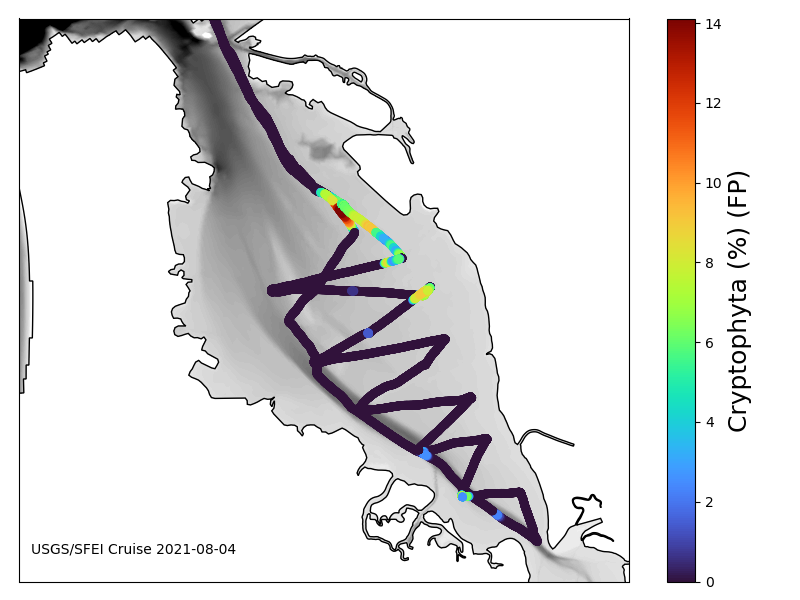

interactive(children=(Dropdown(description='df', options=('2021-03-23', '2021-05-05', '2021-06-23', '2021-08-0…

In [17]:

# Selectively customize labels for plotting
pretty_labels={}

from matplotlib import cm
from matplotlib import colors

def wrap(): # namespace wrangling for interactive figures
    fig,ax=plt.subplots(figsize=(8,6))
    ax.yaxis.set_visible(0)
    ax.xaxis.set_visible(0)
    fig.tight_layout()
    
    cax,ckw = make_axes(ax)
    # South Bay and beyond
    # ax.axis( (540056., 595985., 4141802., 4195927.) )
    # Zoom out enough to see all cruises
    ax.axis( (543682., 583966., 4148657., 4185830.) )
    
    def wrap2(fig=fig,ax=ax,cax=cax):
        def _show_scatter(df,field):
            if isinstance(df,str) or isinstance(df,unicode):
                cruise_name=df
                df=cruises[cruise_name]

            if field not in df:
                print("Field not available",field)
                return
            if np.all(np.isnan(df[field].values)):
                print("Data is all nan for",field)
                return
            zoom=ax.axis()    
            ax.cla()
            cax.cla()
            coll=ax.scatter( df.x,df.y, 40, df[field],
                            cmap=turbo,lw=0)
            # Adjust color scale for specific analytes as needed
            #if 'no3' in field.lower():
            #    # sqrt-normalized, sort of halfway towards log-normalized.
            #    coll.set_norm(colors.PowerNorm(0.5,vmin=0))
            # Special handling for chlorophyll
            # compress the colormap gradients towards the low end of the scale
            # This is effectively a sqrt transform, a bit less severe than a log transform.
            #if 'chl' in field.lower():
            #    # sqrt-normalized
            #    coll.set_norm(colors.PowerNorm(0.5,vmin=0,vmax=80))
                
            cbar=plot_utils.cbar(coll,cax=cax,label=pretty_labels.get(field,field),**ckw)
            # If the bathymetry were in a raster:
            # dem.plot(ax=ax,cmap='gray',vmin=-30,vmax=5,aspect='auto')
            grid.contourf_node_values(grid.nodes['depth'],np.linspace(-30,5,71),cmap='gray',
                                      ax=ax,zorder=-1,extend='both')
            plot_wkb.plot_wkb(poly,facecolor='none',edgecolor='k',zorder=10,ax=ax)
            ax.axis('equal')
            ax.axis(zoom)
            
            label="USGS/SFEI Cruise %s"%(df.time.iloc[0].strftime('%Y-%m-%d'))
            ax.text(0.02,0.05,label,transform=ax.transAxes,ha='left')
            
            plt.setp(cax.yaxis.label,size=18)
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(1.0)
            fig.canvas.draw()
            # return fig
        return _show_scatter
    scatter=wrap2()
    
    return scatter,fig,ax
show_scatter,fig,ax=wrap()

show_scatter('2021-03-23','fCHL (μg/L) (WS)')
gui=widgets.interactive(show_scatter,
                        df=cruises.keys(),
                        field=[fld for fld in dfs[-1].columns.values 
                               if fld not in ['time','Table Names']])
gui

In [21]:
force=True # True: recreate all plots, False: only create plots that are missing

for cruise_name,df in cruises.items():
    if cruise_name=='combined':
        continue
    for fld in df.columns.values:
        fldlow=fld.lower()
        if fld in ['time','Latitude','Longitude','x','y','Table Names']:
            continue
        safe=fld.replace('/','per')
        img_fn=fig_dir+'/basic-%s-%s.png'%(cruise_name,safe)
        if os.path.exists(img_fn) and not force:
            print("Skipping %s"%img_fn)
            continue
            
        show_scatter(cruise_name,fld)
        coll=ax.collections[0]
                    
        fig.patch.set_facecolor('w')
        fig.patch.set_alpha(1)
        fig.savefig(img_fn,facecolor='w',dpi=150)

Data is all nan for fDOM ex310em452 (DUV)
Data is all nan for fDOM ex280em452 (DUV)
Data is all nan for fDOM ex280em350 (DUV)


<IPython.core.display.Javascript object>


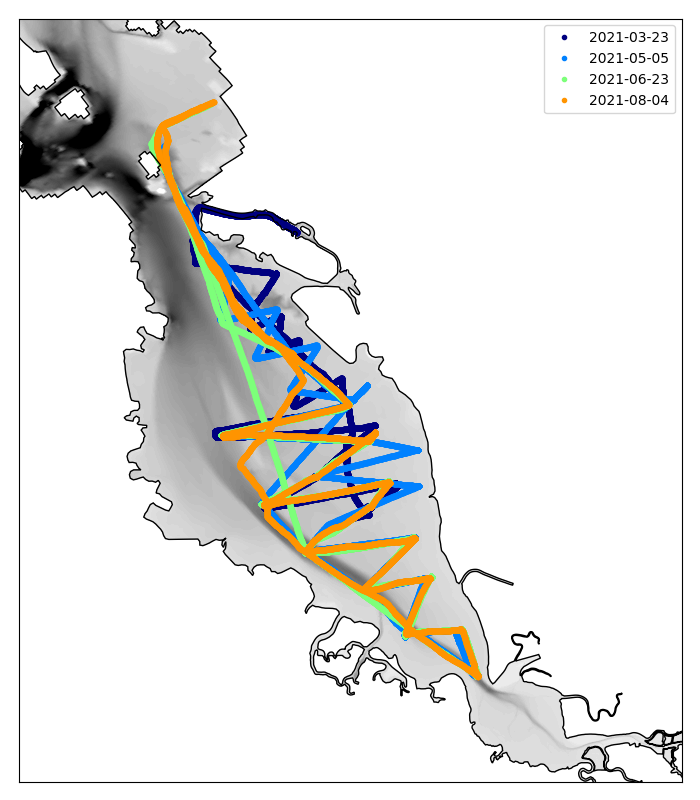

In [65]:
fig,ax=plt.subplots(figsize=(7,8))

#dem.plot(ax=ax,cmap='gray',vmin=-30,vmax=5,aspect='auto')
grid.contourf_node_values(grid.nodes['depth'],np.linspace(-30,5,71),cmap='gray',extend='both',zorder=-2,
                         ax=ax)
plot_wkb.plot_wkb(poly,facecolor='none',edgecolor='k',zorder=10,ax=ax)
ax.axis('equal')
ax.yaxis.set_visible(0)
ax.xaxis.set_visible(0)

cmap=cm.jet

for idx,(cruisedate,df) in enumerate(cruises.items()):
    if cruisedate=='combined': continue
    color=cmap( idx/(len(cruises)-1.0))
    ax.plot( df.x,df.y,label=cruisedate,color=color,marker='.',lw=0)
    
ax.legend()
fig.tight_layout()
ax.axis( (546302., 591927., 4144089., 4196584.))
fig.savefig(fig_dir+'/route-overview.png',dpi=150)

In [73]:
ls figs20211120

basic-2021-03-23-fCHL (μgperL) (EXO).png
basic-2021-03-23-fCHL (μgperL) (WS).png
basic-2021-05-05-fCHL (μgperL) (EXO).png
basic-2021-05-05-fCHL (μgperL) (WS).png
basic-2021-06-23-fCHL (μgperL) (EXO).png
basic-2021-06-23-fCHL (μgperL) (WS).png
basic-2021-08-04-fCHL (μgperL) (EXO).png
basic-2021-08-04-fCHL (μgperL) (WS).png
route-overview.png


In [67]:
raise Exception("This code has not been updated for the 2021 cruises")
from shapely import geometry

# Write out shapefiles for those:
date='2017-03-23'
cruise=cruises[date]

def shorten(f): # shorten field names for annoying shapefile limitation
    if len(f)<=10:
        return f
    f=f.replace('_','')
    f=f.replace('degC','C')
    f=f.replace('DUV','')
    f=f.replace('uScm','')
    f=f.replace('PSU','')
    f=f.replace('ugL','')
    f=f.replace('Salinity','Sal')
    assert len(f)<=10
    return f

fields=dict([ (shorten(f),df[f].values) 
              for f in df.columns
              if f not in ['x','y'] ])

shp_fn='cruise_data-%s.shp'%date

pnts = [geometry.Point(x,y)
        for x,y in zip(df.x,df.y)]

wkb2shp.wkb2shp(shp_fn,pnts,fields=fields,overwrite=True)


Exception: This code has not been updated for the 2021 cruises

In [77]:
pwd

'/richmondvol1/rusty/mapping'